<a class="anchor" id="0"></a>

# **ARIMA Model for Time Series Forecasting: COVID-19 Confirmed Cases in Canada**

<a class="anchor" id="0.1"></a>
# **Table of Contents** 


1.	[Importing Packages and Dataset](#1)
2.	[Introduction to ARIMA Models](#2)
3.	[The meaning of p, d and q in ARIMA model](#3)
4.	[AR and MA models](#4)
5.	[How to find the order of differencing (d) in ARIMA model](#5)
6.	[How to find the order of the AR term (p)](#6)
7.	[How to find the order of the MA term (q)](#7)
8.	[How to handle if a time series is slightly under or over differenced](#8)

# **1. Importing Packages and Dataset** <a class="anchor" id="1"></a>

[Table of Contents](#0.1)


In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima
import statsmodels.api as sm
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams


- Now, we will import the CSV file from a Url and show the top 5 rows of the dataset.

In [2]:
df = pd.read_csv (r'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv',parse_dates=True)
print ('Shape of data', df.shape)
df.head()

Shape of data (10977, 40)


,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
0,35,Ontario,Ontario,2020-01-31,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,59,British Columbia,Colombie-Britannique,2020-01-31,NaN,1,0.0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,35,Ontario,Ontario,2020-02-08,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,59,British Columbia,Colombie-Britannique,2020-02-08,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


- Replacing empty cells with the mean value to ensure dataset is full.

In [3]:
df.isnull().sum()

pruid                     0
prname                    0
prnameFR                  0
date                      0
update                 5270
numconf                   0
numprob                4665
numdeaths               119
numtotal                  0
numtested              6072
numtests                  0
numrecover              524
percentrecover          728
ratetested             6411
ratetests               801
numtoday                  0
percentoday               0
ratetotal               728
ratedeaths              728
numdeathstoday          119
percentdeath            397
numtestedtoday         6072
numteststoday            72
numrecoveredtoday       524
percentactive           397
numactive               397
rateactive              728
numtotal_last14         252
ratetotal_last14        967
numdeaths_last14        252
ratedeaths_last14       967
numtotal_last7          252
ratetotal_last7         967
numdeaths_last7         252
ratedeaths_last7        968
avgtotal_last7      

In [4]:
df.fillna(df.mean(), inplace=True)

C:\Users\prude\AppData\Local\Temp\ipykernel_3584\820435583.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.mean(), inplace=True)


In [5]:
df.corr()

,pruid,update,numconf,numprob,numdeaths,numtotal,numtested,numtests,numrecover,percentrecover,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
pruid,1.000000,-0.047074,-0.283136,-0.037190,-0.352306,-0.283137,-0.193006,-0.317796,-0.278633,0.123338,...,0.019025,-0.209304,0.061046,-0.283681,0.017895,-0.209302,0.061047,-0.283259,0.017859,0.040962
update,-0.047074,1.000000,0.053208,-0.004674,0.067176,0.053208,0.018865,0.063439,0.053559,-0.029934,...,0.069096,0.043950,0.005719,0.050515,0.070508,0.043952,0.005719,0.050449,0.070402,0.142546
numconf,-0.283136,0.053208,1.000000,-0.003737,0.931928,1.000000,0.140346,0.976653,0.995486,0.100941,...,0.157648,0.679877,0.106206,0.517266,0.144499,0.679877,0.106204,0.517405,0.144696,0.080359
numprob,-0.037190,-0.004674,-0.003737,1.000000,-0.000796,-0.003703,-0.008701,-0.005262,0.004102,-0.023651,...,-0.006629,0.000153,-0.002875,0.023730,-0.005972,0.000154,-0.002878,0.023939,-0.005734,-0.004431
numdeaths,-0.352306,0.067176,0.931928,-0.000796,1.000000,0.931928,0.280813,0.962971,0.927262,0.070749,...,0.168358,0.608918,0.056537,0.560529,0.151157,0.608918,0.056535,0.560686,0.151283,0.045814
numtotal,-0.283137,0.053208,1.000000,-0.003703,0.931928,1.000000,0.140346,0.976653,0.995486,0.100940,...,0.157648,0.679878,0.106205,0.517267,0.144499,0.679877,0.106204,0.517406,0.144696,0.080359
numtested,-0.193006,0.018865,0.140346,-0.008701,0.280813,0.140346,1.000000,0.208826,0.118677,-0.016858,...,0.194393,0.247448,0.054330,0.499893,0.187958,0.247450,0.054330,0.500013,0.188223,0.038479
numtests,-0.317796,0.063439,0.976653,-0.005262,0.962971,0.976653,0.208826,1.000000,0.973410,0.106709,...,0.121017,0.650252,0.079467,0.499801,0.111347,0.650252,0.079465,0.499916,0.111531,0.058563
numrecover,-0.278633,0.053559,0.995486,0.004102,0.927262,0.995486,0.118677,0.973410,1.000000,0.111788,...,0.144877,0.646467,0.091934,0.499660,0.132015,0.646466,0.091932,0.499802,0.132197,0.070081
percentrecover,0.123338,-0.029934,0.100941,-0.023651,0.070749,0.100940,-0.016858,0.106709,0.111788,1.000000,...,-0.271466,-0.027717,-0.161640,-0.219744,-0.276323,-0.027719,-0.161641,-0.219282,-0.276273,-0.058278


In [6]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression and Critical Value Calculation :",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

- Next, determine if the p-value is greater than the significance level (0.05).

In [7]:
ad_test(df['numconf'])

1. ADF :  0.9240929309558361
2. P-Value :  0.9933968265004116
3. Num Of Lags :  39
4. Num Of Observations Used For ADF Regression and Critical Value Calculation : 10937
5. Critical Values :
	 1% :  -3.4309480465808004
	 5% :  -2.861804303507452
	 10% :  -2.5669106836275577


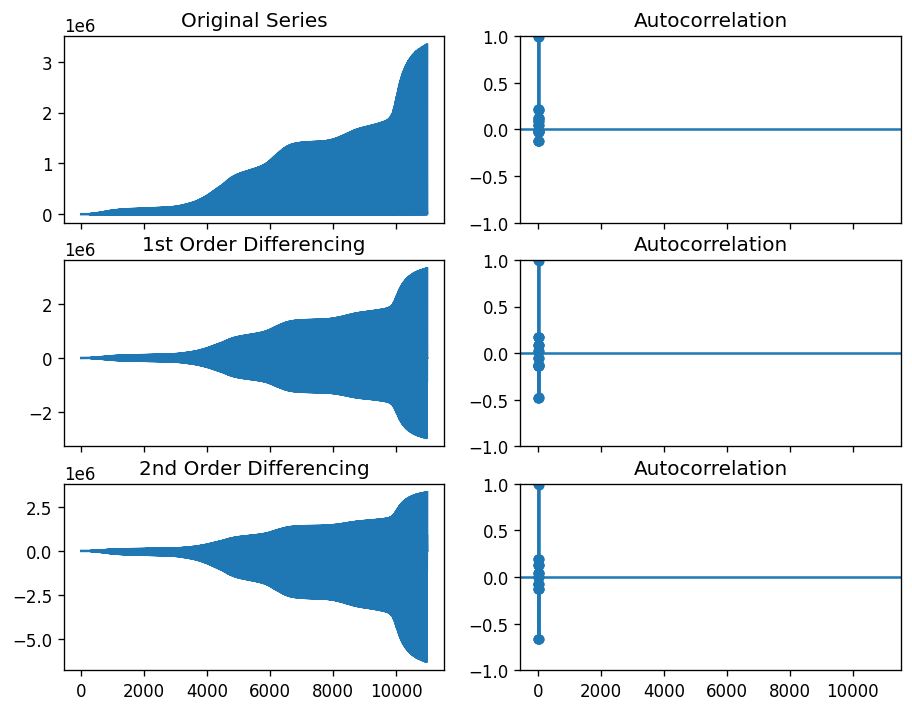

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.numconf); axes[0, 0].set_title('Original Series')
plot_acf(df.numconf, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.numconf.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.numconf.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.numconf.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.numconf.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Figure Out Order for ARIMA Model

In [9]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

Enter the variable in the ' ' below that will be forecasted

In [10]:
stepwise_fit = auto_arima(df['numconf'], trace=True,
                          suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=318754.720, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=315907.388, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=318752.724, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=315096.668, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=314515.971, Time=0.46 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=312823.148, Time=0.60 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=312403.393, Time=0.71 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=310611.256, Time=5.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=310758.042, Time=4.23 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=10.83 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.54 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=5.04 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0] in

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10977
Model:               SARIMAX(5, 1, 1)   Log Likelihood             -155297.628
Date:                Wed, 09 Mar 2022   AIC                         310611.256
Time:                        23:43:05   BIC                         310669.684
Sample:                             0   HQIC                        310630.943
                              - 10977                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    305.2306    123.946      2.463      0.014      62.302     548.160
ar.L1         -0.0433      0.026     -1.647      0.099      -0.095       0.008
ar.L2         -0.0639      0.025     -2.582      0.010      -0.112      -0.015
ar.L3         -0.1553      0.031     -4.942      0.000      -0.217      -0.094
ar.L4         -0.1561      0.025     -6.177      0.000      -0.206      -0.107
ar.L5          0.0911      0.013      6.759      0.000       0.065       0.118
ma.L1         -0.9893      0.004   -255.362      0.000      -0.997      -0.982
sigma2      1.344e+11   1.12e-07    1.2e+18      0.000    1.34e+11    1.34e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):            279514.47
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             165.88   Skew:                             3.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.76e+33. Standard errors may be unstable.
"""

In [11]:
from statsmodels.tsa.arima_model import ARIMA

Split Data into Training and Testing

In [12]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(10977, 40)
(10947, 40) (30, 40)


Train the Model

In [18]:
model=ARIMA(train['numconf'],order=(1,1,2))
model=model.fit()
model.summary()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


Make Predictions on Test Set

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
print(pred)
#pred.index=df.index[start:end+1]
#print(pred)

In [ ]:
pred.plot(legend=True)
test[''].plot(legend=True)

In [ ]:
test[''].mean()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['']))
print(rmse)

In [ ]:
model2=ARIMA(df['Confirmed Positive'],order=(1,0,5))
model2=model2.fit()
df.tail()

For Future Dates

In [ ]:
index_future_dates=pd.date_range(starts='',end='')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
#print(comp_pred)

In [ ]:
pred.plot(figsize=(12,5),legend=True)